In [1]:
!pip install pacmap

  Created wheel for annoy: filename=annoy-1.17.0-cp38-cp38-win_amd64.whl size=53041 sha256=0e685ba429a1c010b7b74ec922b4b5e22d4835a547d4dc7006a19d0ed2c3cba8
  Stored in directory: c:\users\emrek\appdata\local\pip\cache\wheels\77\01\de\4421524f9997a25dfa7291121565d12ef514154945e80e907a
Successfully built annoy


In [13]:
!pip install openpyxl

In [271]:
import numpy as np
import pandas as pd
import glob
import pacmap
import matplotlib.pyplot as plt
from annoy import AnnoyIndex
from tqdm import tqdm

In [2]:
filelist = glob.glob('*.xlsx')
filelist

['play1.xlsx',
 'play10.xlsx',
 'play2.xlsx',
 'play3.xlsx',
 'play4.xlsx',
 'play5.xlsx',
 'play6.xlsx',
 'play7.xlsx',
 'play8.xlsx',
 'play9.xlsx']

In [261]:
def file2array(fname):
    # 1 for black, 2 for white, 0 for empty cells in the grid
    
    df = pd.read_excel(fname)
    num_step = len(df)
    state = np.zeros((13, 13, num_step))
    row, col = df['Black'][0].split(',')
    row, col = int(row), int(col)
    state[row, col, 0] = 1
    win = df['win'][0].lower()
    
    for i in range(1, num_step):
        
        state[:, :, i] = state[:, :, i-1]
        
        if i % 2 == 0:
            row, col = df['Black'][i].split(',')
            row, col = int(row), int(col)
            state[row, col, i] = 1
        else:
            row, col = df['White'][i].split(',')
            row, col = int(row), int(col)
            state[row, col, i] = 2
        
    return win, state, num_step

In [263]:
plays = []
wins = []
num_games = len(filelist)
num_steps = []

for i, f in enumerate(filelist):
    win, state, num_step = file2array(f)
    print(str(i+1)+'. game has shape of ' + str(state.shape) + ', winning side --> ' + win +
         ', ' + str(num_step) + ' time steps.')
    plays.append(state)
    wins.append(win)
    num_steps.append(num_step)

1. game has shape of (13, 13, 13), winning side --> black, 13 time steps.
2. game has shape of (13, 13, 18), winning side --> white, 18 time steps.
3. game has shape of (13, 13, 16), winning side --> white, 16 time steps.
4. game has shape of (13, 13, 14), winning side --> white, 14 time steps.
5. game has shape of (13, 13, 38), winning side --> white, 38 time steps.
6. game has shape of (13, 13, 28), winning side --> white, 28 time steps.
7. game has shape of (13, 13, 17), winning side --> black, 17 time steps.
8. game has shape of (13, 13, 21), winning side --> black, 21 time steps.
9. game has shape of (13, 13, 22), winning side --> white, 22 time steps.
10. game has shape of (13, 13, 16), winning side --> white, 16 time steps.


In [259]:
X_transformed = [pacmap.PaCMAP(n_dims=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0).fit_transform(p.reshape(13*13, -1), 
                                                                                            init="pca") for p in plays]
X_transformed = [pacmap.PaCMAP().fit_transform(p.reshape(13*13, -1), init="pca") for p in plays]
X_transformed = np.array(X_transformed)
print(X_transformed.shape)
print('(Num games, grid size, n_dims)')

(10, 169, 2)
(Num games, grid size, n_dims)


# Visualize the embedding

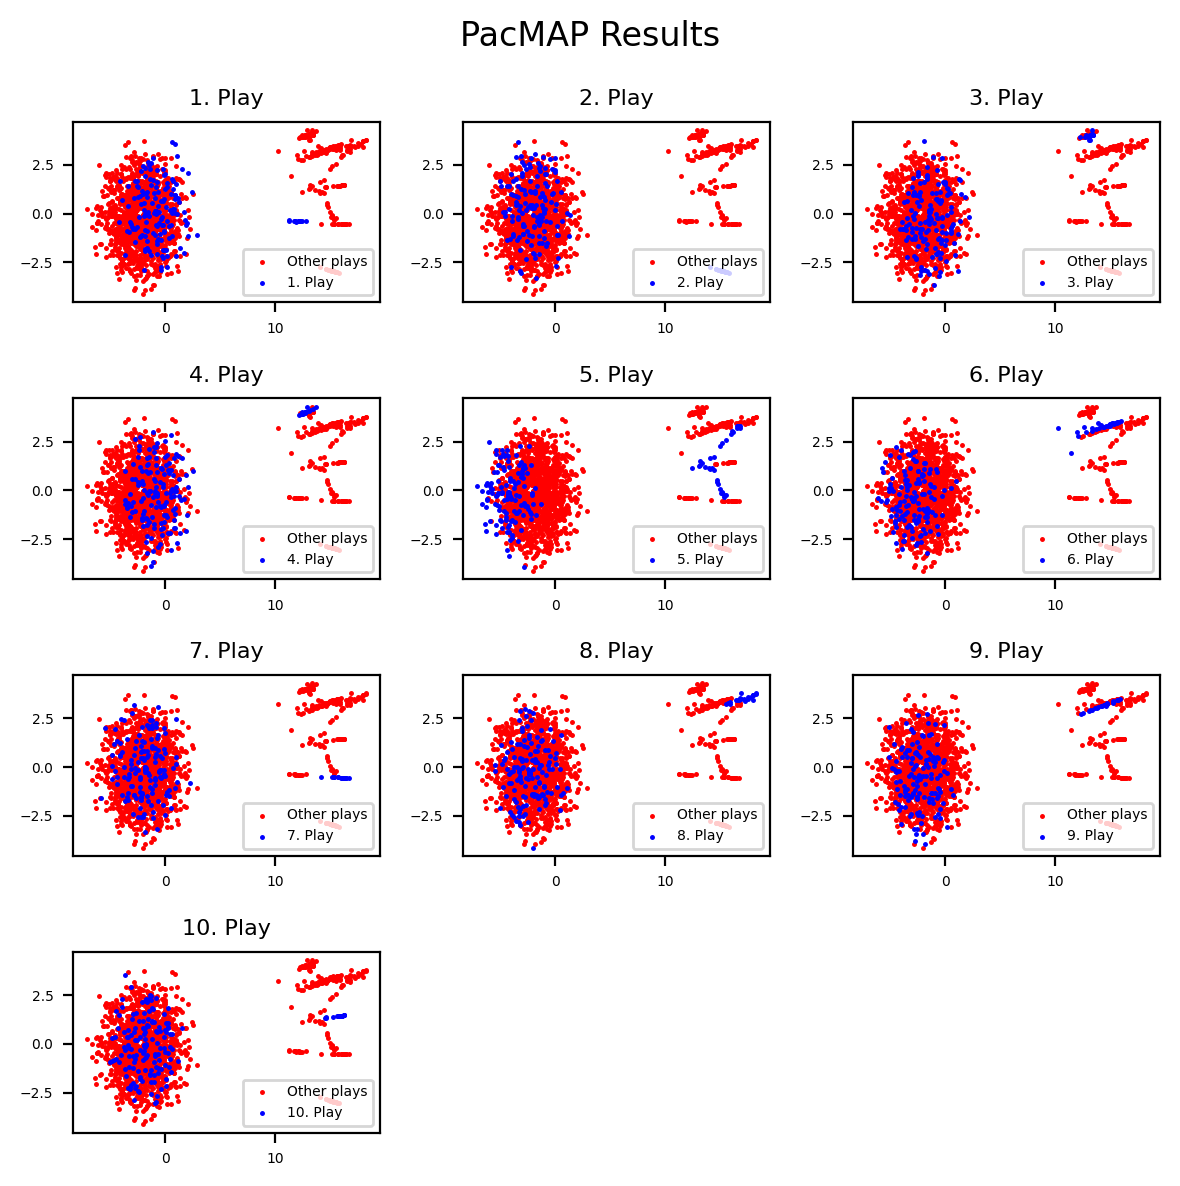

In [239]:
fig, ax = plt.subplots(4, 3, figsize=(6, 6), dpi = 200)
plt.suptitle('PacMAP Results')

for i in range(num_games):
    y = np.zeros((num_games,)).astype(int)
    y[i] = 1
    plt.subplot(4, 3, i+1)
    
    for yy in range(len(y)):
        if not y[yy]:
            p1 = plt.scatter(X_transformed[yy, :, 0], X_transformed[yy, :, 1],color='r', s=0.6)
        
    p2 = plt.scatter(X_transformed[i, :, 0], X_transformed[i, :, 1], color='b', s=0.6)
    
    plt.legend(handles=[p1, p2], labels=['Other plays', str(i+1) + '. Play'], fontsize=5)
    plt.title(str(i+1)+'. Play', fontsize = 8)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
fig.delaxes(ax[3][1])
fig.delaxes(ax[3][2])
fig.tight_layout()

# Trajectory (N, dims)

In [255]:
# All games combined w.r.t n_steps
xls = np.array([p.reshape(-1,13*13) for p in plays], dtype=object)
xls = np.vstack(xls)
xls.shape

(203, 169)

In [265]:
# x_tranform = pacmap.PaCMAP().fit_transform(xls)
x_transform = pacmap.PaCMAP(n_dims=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0).fit_transform(xls, init="pca")
x_transform.shape

(203, 2)

# Visualize the embedding

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.42it/s]


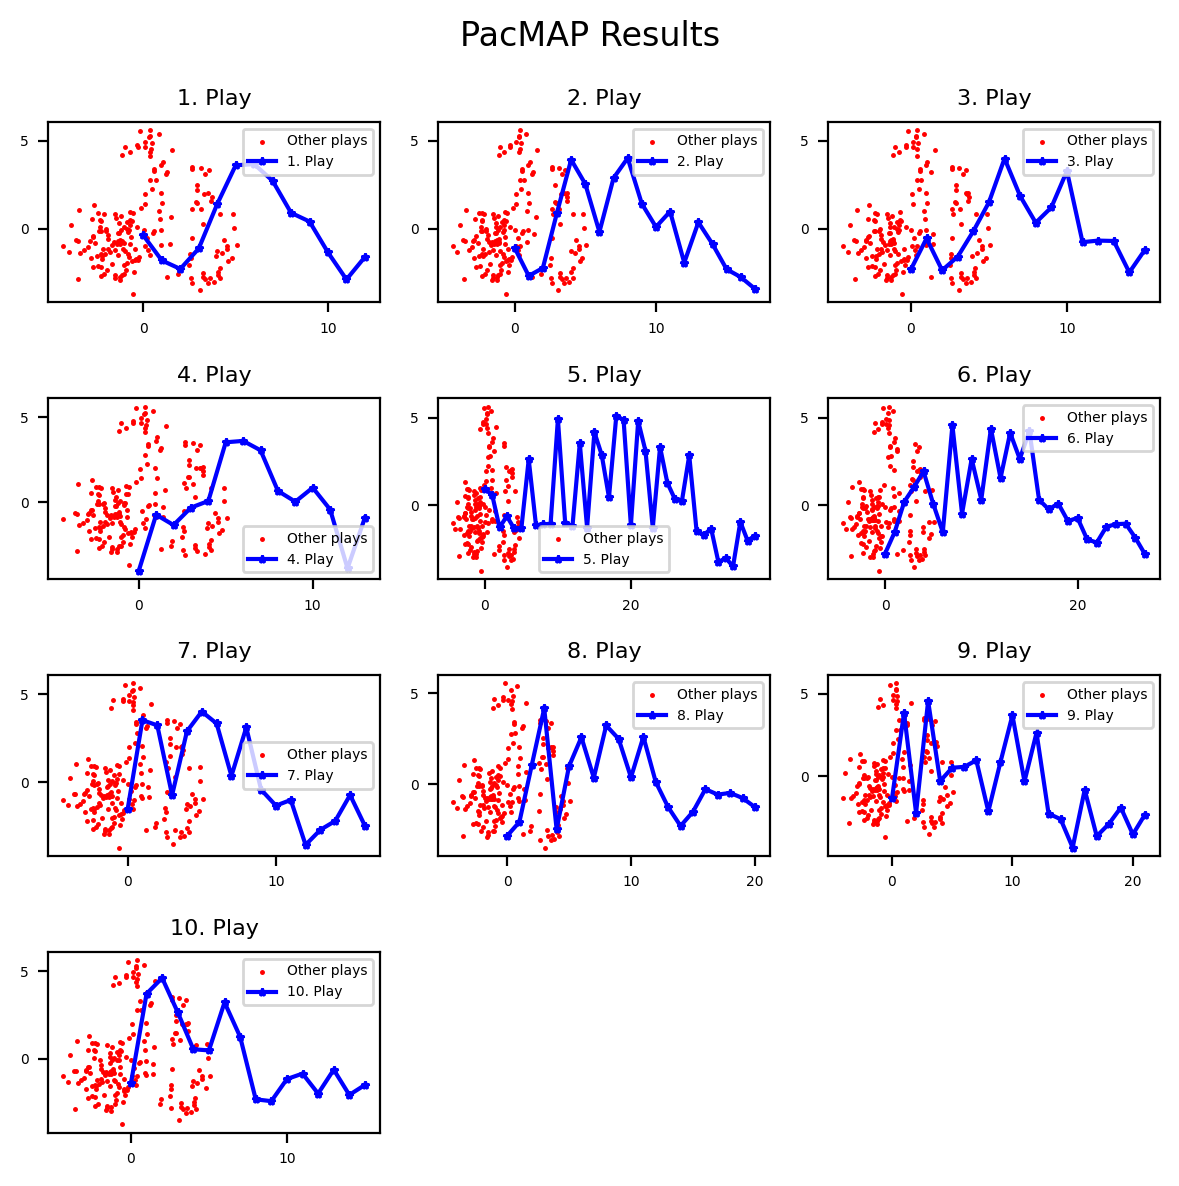

In [288]:
fig, ax = plt.subplots(4, 3, figsize=(6, 6), dpi = 200)
plt.suptitle('PacMAP Results')

for i in tqdm(range(num_games)):
    y = np.zeros((len(x_transform),)).astype(int)
    start_idx = int(np.sum([num_steps[p] for p in range(i)]))
    end_idx = start_idx + num_steps[i]
    y[start_idx:end_idx] = 1
    
    plt.subplot(4, 3, i+1)
    
    for yy in range(len(y)):
        if not y[yy]:
            p1 = plt.scatter(x_transform[yy, 0], x_transform[yy, 1],color='r', s=0.6)
#         else:
#             p2 = plt.scatter(x_transform[yy, 0], x_transform[yy, 1], color='b', s=0.6)
    p2, = plt.plot(x_transform[start_idx:end_idx, 0], marker='*', markersize=3, color='b')
    plt.legend(handles=[p1, p2], labels=['Other plays', str(i+1) + '. Play'], fontsize=5)
    plt.title(str(i+1)+'. Play', fontsize = 8)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
fig.delaxes(ax[3][1])
fig.delaxes(ax[3][2])
fig.tight_layout()
plt.savefig('PaCMAP v1.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.39it/s]


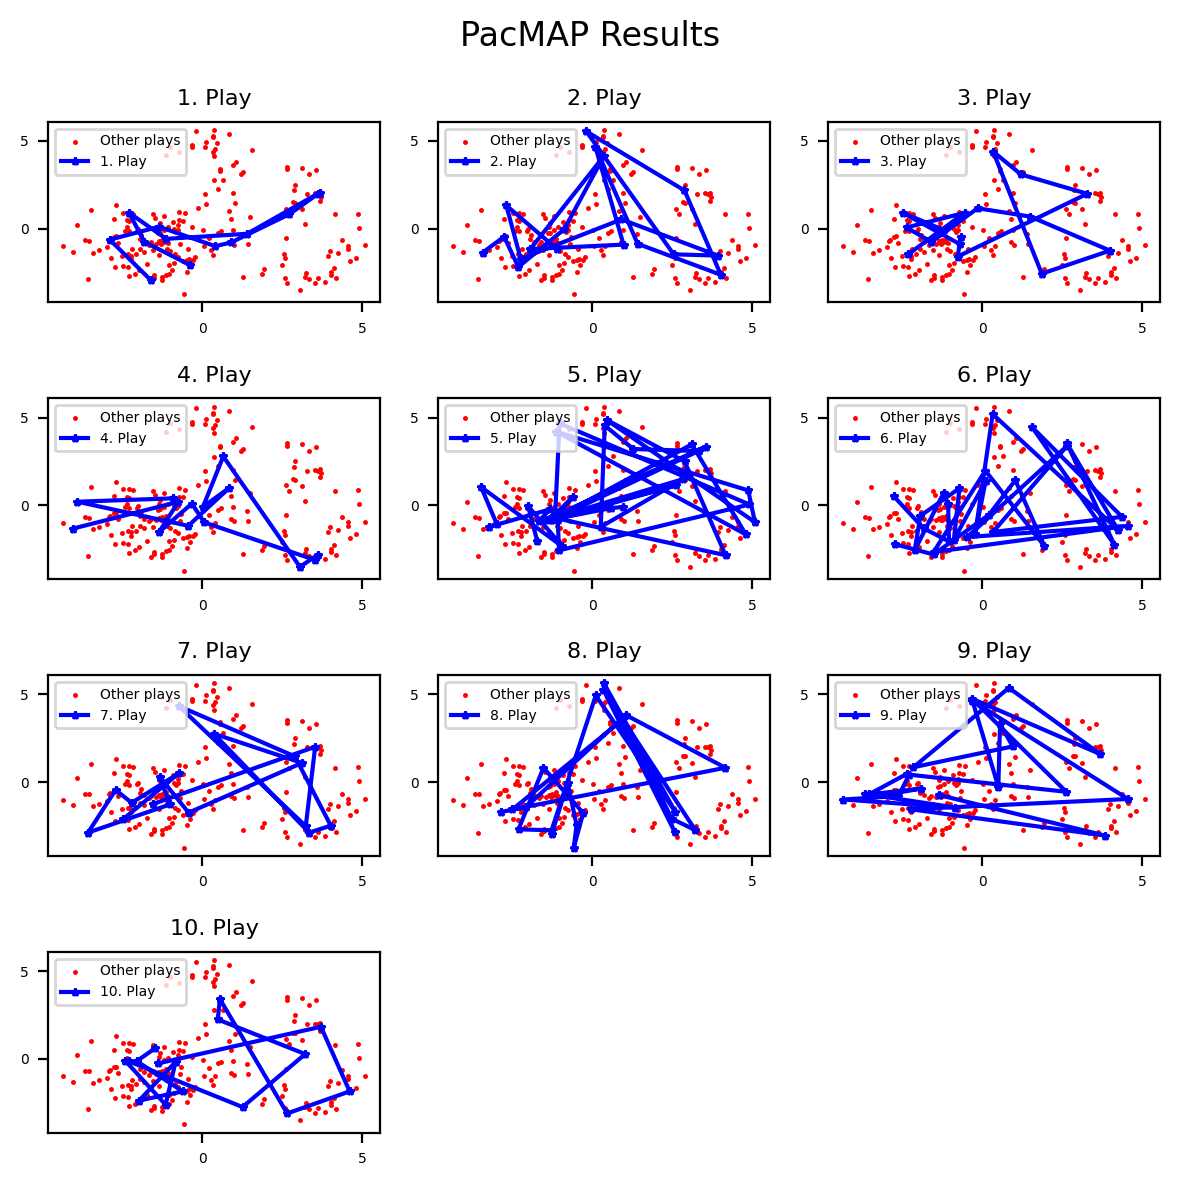

In [287]:
fig, ax = plt.subplots(4, 3, figsize=(6, 6), dpi = 200)
plt.suptitle('PacMAP Results')

for i in tqdm(range(num_games)):
    y = np.zeros((len(x_transform),)).astype(int)
    start_idx = int(np.sum([num_steps[p] for p in range(i)]))
    end_idx = start_idx + num_steps[i]
    y[start_idx:end_idx] = 1
    
    plt.subplot(4, 3, i+1)
    
    for yy in range(len(y)):
        if not y[yy]:
            p1 = plt.scatter(x_transform[yy, 0], x_transform[yy, 1],color='r', s=0.6)
#         else:
#             p2 = plt.scatter(x_transform[yy, 0], x_transform[yy, 1], color='b', s=0.6)
    p2, = plt.plot(x_transform[start_idx:end_idx, 0], x_transform[start_idx:end_idx, 1], marker='*', markersize=3, color='b')
    plt.legend(handles=[p1, p2], labels=['Other plays', str(i+1) + '. Play'], fontsize=5)
    plt.title(str(i+1)+'. Play', fontsize = 8)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
fig.delaxes(ax[3][1])
fig.delaxes(ax[3][2])
fig.tight_layout()
plt.savefig('PaCMAP v2.png')